# Prediction of Molecular Pathways and Key Mutations

Click to open in: [[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/tree/master/examples/inference-pipelines/idars.ipynb)][[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/master/examples/inference-pipelines/idars.ipynb)][[Kaggle](https://kaggle.com/kernels/welcome?src=https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/inference-pipelines/idars.ipynb)]


_In order to run this notebook on a Kaggle platform, 1) click on the blue checkbox_ "[Kaggle]" _above 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick the "Internet" checkbox under Settings, to enable necessary downloads._

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. If the left click does not work, you can right-click on the blue checkbox "[Colab]" above and select "Open in new tab" . Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

# About this demo
Prediction of molecular pathways and key mutations directly from Haematoxylin and Eosin stained histology images may help bypass additional genetic (e.g., polymerase chain reaction or PCR) or immunohistochemistry (IHC) testing, which can therefore save both money and time.

In this example notebook, we show how you can use pretrained models to reproduce inference results such as those described <a href="https://www.thelancet.com/journals/landig/article/PIIS2589-7500(2100180-1/fulltext">here</a> (_Bilal et al., "Development and validation of a weakly supervised deep learning framework to predict the status of molecular pathways and key mutations in colorectal cancer from routine histology images: a retrospective study"_).  The site also carries important _Supplementary Materials_. These sources give details of the models we use.

## The IDaRS algorithm (Iterative Draw and Rank Sampling)
This deep-learning algorithm is perhaps the most important contribution of the paper. It infers patch-level (or tile-level) labels from slide-level labels, transforming information that is originally known only globally into local information. It is novel, general, fast and as accurate as might be hoped for from such an algorithm. For a tile (or patch) $T$, let $p(T)$ denote the slide-level binary label `False|True = 0|1` of the WSI containing $T$, denoting whether the WSI displays a certain feature $F$, perhaps a genetic abnormality (as determined by PCR or IHC, for example). So all tiles in the same WSI have exactly the same $p$ label. Let $q(T)$ be the 'probability' of $T$ having the feature $F$. The loss function is cross entropy (or some variant of it), defined by:
$$ -\sum_{T\in C}(p(T)\log(q(T)) + (1 - p(T))\log(1 -q(T))),$$
where $C$ is some set of tiles. When $q$ is allowed to range over all possible $q:C\to[0,1]$, this function has a unique minimum and local minimum at $q=p$, when its value is 0. However, here $q(T)$ is constrained to depend only on the pixel values of $T$, and the cross entropy is, in practice, strictly positive. Pseudocode for the algorithm follows.

$ts$ = empty set \# $ts$=training set<br>
for each labelled WSI $W_i$<br>
....create the subset $S_i$ of tumour tiles<br>
....add $r+k$ randomly chosen tiles of $S_i$ to $ts$<br>
for each epoch<br>
....\# process $ts$, fast because $ts$ is small<br>
....randomise and divide $ts$ into batches of a fixed size<br>
....for each batch<br>
........calculate loss per tile<br>
........ieverage and backpropagate the loss per batch<br>
....\# prepare next training set $nt$<br>
....$nt$ = empty set<br>
....for each $W_i$<br>
........add to $nt$ $k$ top probability tiles in $S_i\cap ts$ <br>
............\# alternatively use $k$ tiles with smallest loss<br>
........add to $nt$ $r$ further tiles randomly chosen from $S_i$<br>
....$ts$ = $nt$

In TIAToolbox, we include models that are capable of predicting:
- Microsatellite instability (MSI)
- Hypermutation density
- Chromosomal instability
- CpG island methylator phenotype (CIMP)-high prediction
- BRAF mutation
- TP53 mutation

## Available models
In line with the above description, in TIAToolbox, we provide the following pretrained models used in the <a href="https://www.thelancet.com/journals/landig/article/PIIS2589-7500(2100180-1/fulltext">original publication</a>:

- Tumour segmentation
    - `resnet18-idars-tumour`
- Task specific prediction
    - MSI: `resnet34-idars-msi`
    - Hypermutation density: `resnet34-idars-hm`
    - Chromosomal instability: `resnet34-idars-cin`
    - CpG island methylator phenotype (CIMP)-high prediction: `resnet34-idars-cimp`
    - BRAF mutation: `resnet34-idars-braf`
    - TP53 mutation: `resnet34-idars-tp53`

The provided models are trained on the first fold used in the original paper.

### Setting up the environment

If on Colab or Kaggle or any other platform with Cuda-enabled GPU, you can substantially speed up execution by using the`torch` package and a GPU. This is the default, with `ON_GPU==True`. If you can't or do not want to do this, set `ON_GPU=False`, in which case, the notebook will probably take several hours to complete.

In [1]:
ON_GPU = True # change to False to run without GPU (Slow)

You can skip the following cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [2]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox | tail --line 1

Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


If `ON_GPU` is `True` install the torch package. Disregard errors reported by `pip`.

In [3]:
if ON_GPU:
    !pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
     |████████████████████████████████| 831.4 MB 7.3 kB/s 
     |████████████████████████████████| 22.1 MB 58.1 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1+cu102 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.1+cu102 which is incompatible.


The cell below removes the directory `tmp` if it exists—a previous run may have created it.
It creates a new tmp directory, for storing downloaded or newly created files.

In [4]:
![ -d tmp ] && ( echo "deleting old tmp directory"; rm -rf tmp )
!( echo "creating new tmp directory"; mkdir tmp)

creating new tmp directory


### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [5]:
from tiatoolbox.models.engine.patch_predictor import PatchPredictor
from tiatoolbox.utils.misc import imwrite
from tiatoolbox.wsicore.wsireader import get_wsireader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 140 # for high resolution figure in notebook

|2022-04-10|08:48:28.072| [INFO] NumExpr defaulting to 2 threads.


### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a whole slide image of cancerous colon tissue to highlight how the pipeline works.
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 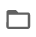

In [6]:
import requests

wsi_file_name = "tmp/sample_wsi.svs"
print('Download has started. Please wait...')

# Downloading sample TCGA whole-slide image
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-AD-6964-01Z-00-DX1.83AF88B9-C59B-48C6-A739-85ACB8F8ECA9.svs")
with open(wsi_file_name, "wb") as f:
    f.write(r.content)

print('Download is complete.')

Download has started. Please wait...
Download is complete.


## Tumour segmentation using TIAToolbox pretrained models
In this section, we will display patch-level tumour segmentation results using a pretrained model used in the original paper by Bilal _et al_. In particular, this model is a ResNet model with 18 layers (resnet18). A prediction is made for each input patch, which denotes the probability of being tumour.

In line with the patch prediction model provided in `tiatoolbox`, the tumour segmentation model can be applied to input patches, large images tiles or whole-slide images. In order to replicate the original pipeline, we choose to process a sample whole-slide image. It can be seen that we can perform inference on a WSI with minimal effort. First we create the `PatchPredictor` object, which denotes the pretrained model that we will use, along with other arguments, such as the batch size and number of workers. More information on using the `PatchPredictor` functionality can be seen in the dedicated patch prediction notebook.

In [7]:
wsi_file_list = [wsi_file_name] # the list of WSIs to process- in this example we just use a single WSI.

if ON_GPU:
    WORKERS = 8 # if crash below, check ON_GPU in first code cell and reduce WORKERS
else:
    WORKERS = 0
print('ON_GPU', ON_GPU,':', WORKERS, 'WORKERS')
    
tumour_predictor = PatchPredictor(
    pretrained_model='resnet18-idars-tumour',
    batch_size=64,
    num_loader_workers=WORKERS)

ON_GPU True : 8 WORKERS


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet18-idars-tumour.pth
Save to /root/.tiatoolbox/models/resnet18-idars-tumour.pth


We next call the `predict` method to process the slide and return the results. If a crash results, check `ON_GPU` in first code cell and reduce the number of `WORKERS`(see previous code cell), trying, for example 8→4→2→1

In [8]:
tumour_output = tumour_predictor.predict(
    imgs=wsi_file_list,
    mode='wsi',
    return_probabilities=True,
    on_gpu=ON_GPU)

|2022-04-10|08:48:49.545| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsireader.py:359: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."

|2022-04-10|08:49:06.211| [WARNING] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

100%|###########################################| 24/24 [02:43<00:00,  6.80s/it]


As can be seen above, with just a few lines of code we are able to perform tumour segmentation on whole-slide images. If running the prediction like we did above, then the default parameters for `patch_shape`, `stride_shape` and `resolution` will be used. Here, `patch_shape`, and `resolution` are in line with what was used for training the model, whereas `stride_shape` is set to be equal to the `patch_shape` (no overlap). In particular, the input patch size is 512x512 and the processing resolution is 0.5 microns per pixel (~20x objective magnification).

If you want to change the default parameters, you will need to define this using `IOPatchPredictorConfig`. For example, you may want to run with 50% overlap between neighbouring patches. Therefore, you would define:

```
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[{'units': 'mpp', 'resolution': 0.5}],
    patch_input_shape=[512, 512],
    stride_shape=[256, 256],
)
```

Then, you would add this in the `predict` method as follows:

```
tumour_output = tumour_predictor.predict(
    imgs=[wsi_file_name],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True
    ioconfig=wsi_ioconfig)
```

Below, we show how to merge the output predictions to form a 2-dimensional prediction map, denoting areas predicted as tumour. This prediction map is used in the second step of the pipeline, where we use only patches containing tumour.

In [9]:

overview_resolution = 1.25 # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "power" # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"

# merge predictions to form a 2-dimensional output at the desired resolution
tumour_mask = tumour_predictor.merge_predictions(
    wsi_file_name, tumour_output[0],
    resolution=overview_resolution,
    units=overview_unit)

# the output map will contain values from 0 to 2.
# 0: background that is not processed, 1: non-tumour prediction and 2 is tumour predictions
tumour_mask = tumour_mask == 2 # binarise the output

# let's save the tumour mask, so that we can use it in stage 2!
imwrite('tmp/tumour_mask.png', tumour_mask.astype('uint8') * 255)

|2022-04-10|08:51:49.473| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsireader.py:359: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."



Now that we have merged the prediction, let's visualise the results!

|2022-04-10|08:51:49.891| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsireader.py:359: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."



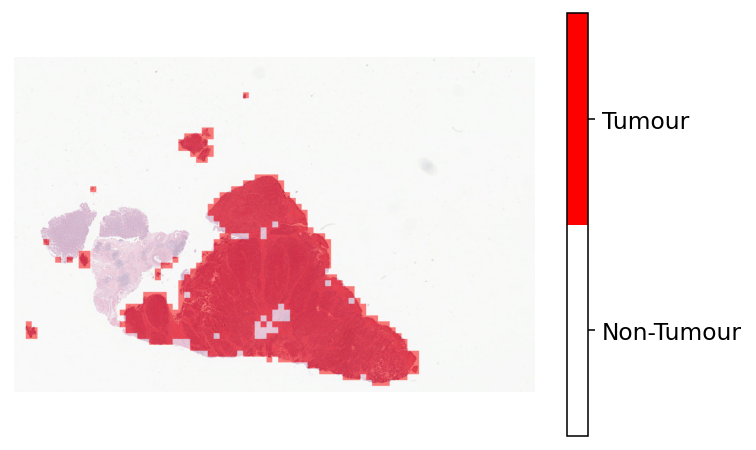

In [10]:
from tiatoolbox.utils.visualization import overlay_prediction_mask

# first read the WSI at a low-resolution. Here, we use the same resolution that was used when merging the patch-level results.
wsi = get_wsireader(wsi_file_name)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)

# [Overlay map creation]
# creating label-color dictionary to be fed into `overlay_prediction_mask` function to help generate a color legend
label_dict = {'Non-Tumour': 0, 'Tumour': 1}
label_color_dict = {}
colors = [[255, 255, 255], [255, 0, 0]] # defining colours for overlay (white and red)
for class_name, label in label_dict.items():
    label_color_dict[label] = (class_name, np.array(colors[label]))

overlay = overlay_prediction_mask(wsi_overview, tumour_mask, alpha=0.5, label_info=label_color_dict)
plt.show()

## WSI prediction using TIAToolbox pretrained models
Next, we show how one can use a second CNN that takes as input the results obtained from part 1 and gives a prediction for each tumour patch in the input WSI. In the original paper, 4 fold cross validation was used. In the toolbox, we choose to provide models trained on the first fold of the data, which enables us to cross check the results and ensure that they are in line with the original work. All models in the second step of the pipeline are ResNet34.

To speed up this step, we choose to retrain the models without stain normalization (as oppoed to the original IDaRS) and instead with colour jitter. We report the difference in results at the end of this notebook.

Near the beginning of the notebook, we mention which prediction tasks we consider. Next, we will run inference for all of these prediction tasks and visualise the output.

In [11]:
# Run inference for each of the 6 WSI prediction tasks
prediction_tasks = ['msi', 'braf', 'cimp', 'cin', 'hm', 'tp53']

# iterate over each of the prediction tasks and add the results to a dictionary
wsi_output_dict = {}
for task in prediction_tasks:
    wsi_predictor = PatchPredictor(
        pretrained_model='resnet34-idars-%s' % task,
        batch_size=64,
        num_loader_workers=WORKERS)

    # we include the obtained tumour mask from stage 1 as an argument so that we only process patches from those regions.
    wsi_output_dict[task] = wsi_predictor.predict(
        imgs=wsi_file_list,
        masks=['tmp/tumour_mask.png'],
        mode='wsi',
        return_probabilities=True,
        on_gpu=ON_GPU)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-msi.pth
Save to /root/.tiatoolbox/models/resnet34-idars-msi.pth


|2022-04-10|08:52:20.205| [WARNING] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

100%|###########################################| 22/22 [01:41<00:00,  4.63s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-braf.pth
Save to /root/.tiatoolbox/models/resnet34-idars-braf.pth


100%|###########################################| 22/22 [01:40<00:00,  4.55s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-cimp.pth
Save to /root/.tiatoolbox/models/resnet34-idars-cimp.pth


100%|###########################################| 22/22 [01:38<00:00,  4.46s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-cin.pth
Save to /root/.tiatoolbox/models/resnet34-idars-cin.pth


100%|###########################################| 22/22 [01:41<00:00,  4.61s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-hm.pth
Save to /root/.tiatoolbox/models/resnet34-idars-hm.pth


100%|###########################################| 22/22 [01:39<00:00,  4.52s/it]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-tp53.pth
Save to /root/.tiatoolbox/models/resnet34-idars-tp53.pth


100%|###########################################| 22/22 [01:41<00:00,  4.59s/it]


Now that we have performed patch-level classification for each tumour patch, let's merge together the results to get the 2D prediction map. Here, we return the raw probability map, rather than the class predictions. We do this because the final step in the IDaRS pipeline uses the raw patch-level probabilities to classify each WSI.

In [12]:
overview_resolution = 1.25 # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "power" # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"

# merge predictions to form a 2-dimensional output at the desired resolution
merged_output_dict = {}
for task in prediction_tasks:
    merged_output = PatchPredictor.merge_predictions(wsi_file_name, wsi_output_dict[task][0], resolution=overview_resolution, units=overview_unit, return_raw=True)
    merged_output_dict[task] = merged_output[..., 1] # consider only the positive class

|2022-04-10|09:04:41.613| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsireader.py:359: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."



Now that we have merged the predictions to obtain the probability map, let's visualise the results. This is very similar to the `overlay_patch_prediction` function, but `label_info` does not need to be provided because we only have one class. Also, `min_val` can be provided. This is a number between 0 and 1 which ensures that the probability map is only shown for values greater than `min_val`.

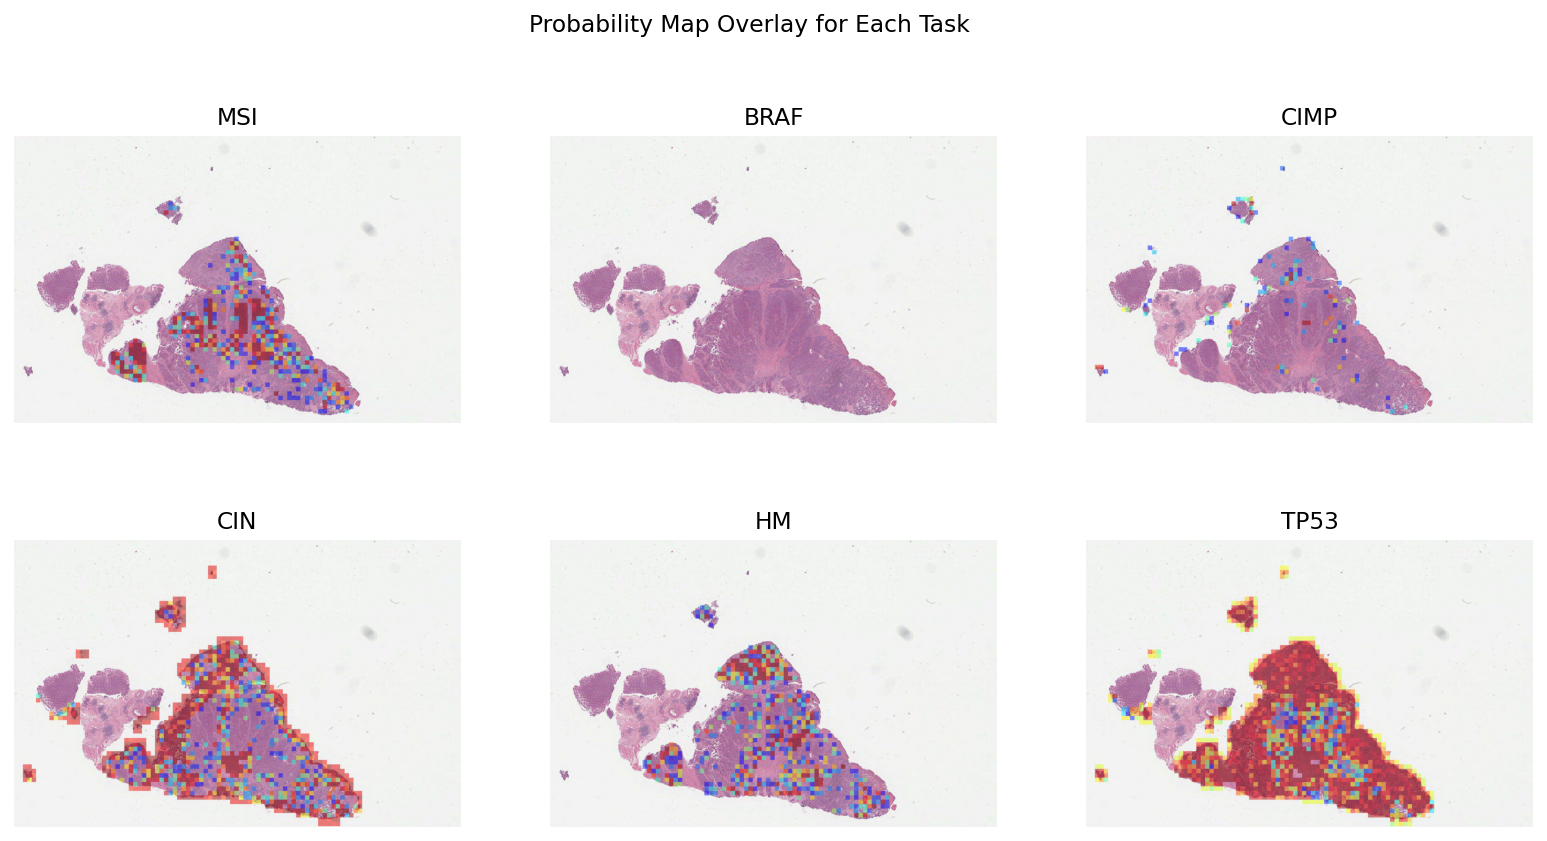

In [13]:
from tiatoolbox.utils.visualization import overlay_probability_map

# [Overlay map creation]
# iterate over the tasks and generate the probability map
overlay_list = []
for task in prediction_tasks:
    # only show the probability map when it is greater than `min_val` (0.1 is used here)
  overlay_prob_map = overlay_probability_map(wsi_overview, merged_output_dict[task], alpha=0.5, min_val=0.1, return_ax=False)
  overlay_list.append(overlay_prob_map)

# visualise the overlays in a single plot
fig = plt.figure(figsize=(14,7))
for i in range(6):
  ax = plt.subplot(2,3,i+1)
  plt.imshow(overlay_list[i])
  plt.axis('off')
  plt.title(prediction_tasks[i].upper())
fig.suptitle('Probability Map Overlay for Each Task')

plt.show()

These probability maps can be used to increase the interpretability of results and help identify regions contributing to the overall prediction. To get a smoother output, you can increase the overlap by modifying `IOPatchPredictorConfig`.

Let's visualise some patches that have either a high probability or a low probability of being MSI positive. For this, we randomly sample 4 patches with probability of being MSI > 0.95 and 4 patches with probability of being MSI < 0.05.

In [14]:
# get the probabilities of each processed patch being MSI
msi_probabilities = wsi_output_dict['msi'][0]['probabilities']
msi_probabilities = np.array(msi_probabilities)[..., 1]

# get the coordinates of each processed patch
msi_coordinates = wsi_output_dict['msi'][0]['coordinates']
msi_coordinates = np.array(msi_coordinates)

# subset where MSI probability is greater than 0.95
msi_probabilities_subset_pos = msi_probabilities[msi_probabilities > 0.95]
msi_coordinates_subset_pos = msi_coordinates[msi_probabilities > 0.95]

# subset where MSI probability is less than than 0.05
msi_probabilities_subset_neg = msi_probabilities[msi_probabilities > 0.05]
msi_coordinates_subset_neg = msi_coordinates[msi_probabilities > 0.05]
msi_coordinates_subset = list(msi_coordinates_subset_pos) + list(msi_coordinates_subset_neg)

# randomly sample 4 positive and 4 negative
random_pos_idx = np.random.randint(0, msi_probabilities_subset_pos.shape[0], size=4)
random_neg_idx = np.random.randint(0, msi_probabilities_subset_neg.shape[0], size=4)
random_idx = list(random_pos_idx) + list(random_neg_idx)

Now that we have obtained our random sample, let's plot the patches! First, we use TIAToolbox's `WSIReader` to read the original WSI and extract patches at defined locations. For detailed information on this, see the relevant example notebook!

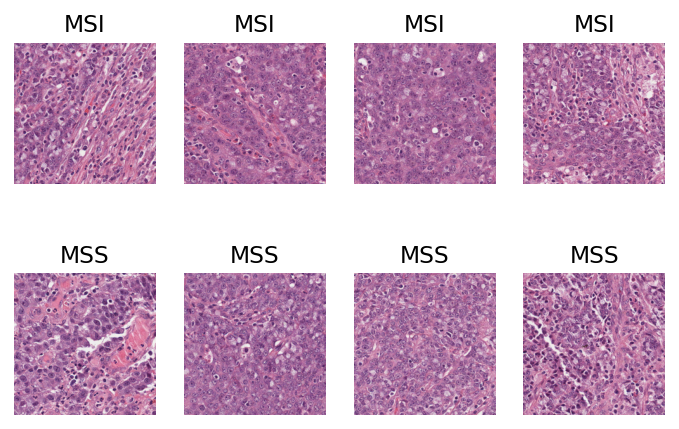

In [15]:
# read the WSI and get the resolution used during processing.
wsi_reader = get_wsireader(input_img=wsi_file_name)
resolution = wsi_output_dict['msi'][0]['resolution']
units = wsi_output_dict['msi'][0]['units']

# visualise the overlays in a single plot
fig = plt.figure()
for i in range(8):
  ax = plt.subplot(2,4,i+1)
  coords = msi_coordinates_subset[random_idx[i]]
  size = (coords[2]-coords[0], coords[3]-coords[1]) # determine the size of patch from the coordinates
  # get the patch
  patch = wsi_reader.read_rect((coords[0]*4, coords[1]*4), size, resolution=resolution, units=units)
  plt.imshow(patch)
  plt.axis('off')
  if i < 4:
    plt.title('MSI')
  else:
    plt.title('MSS')
plt.show()

The probability maps are not directly needed to obtain the WSI-level score. Below, we will demonstrate how one can obtain the WSI score utilising the output from the `PatchPredictor` in step 2. For the purpose of this example, we will show how to use mean and max aggregation to obtain a slide-level prediction score.

First, let's examine the format of the dictionary output by `PatchPredictor`. We look only at the MSI output as an example, but the output from each task is similar.

In [16]:
# get the keys of the dictionary returned at the output of the MSI CNNPatchPredictor
print('Output of PatchPredictor:')
print(list(wsi_output_dict['msi'][0].keys()))

Output of PatchPredictor:
['probabilities', 'predictions', 'coordinates', 'label', 'pretrained_model', 'resolution', 'units']


As we can see, the probabilities are returned as output. Now, let's compute, for each task, the average and maximum over all probabilities of tumour tiles being positive.

In [17]:
slide_score_mean = {}
slide_score_max = {}
# iterate over the tasks
for task in prediction_tasks:
    probabilities = np.array(wsi_output_dict[task][0]['probabilities'])[...,1] # only consider positive class
    slide_score_mean[task] = np.mean(probabilities) # get the average probability over all tumour tiles
    slide_score_max[task] = np.max(probabilities) # get the maximum probability over all tumour tiles


# print the scores
print('MEAN AGGREGATION')
for task, value in slide_score_mean.items():
    print(task, ':', value)

print('-'*30)

print('MAX AGGREGATION')
for task, value in slide_score_max.items():
    print(task, ':', value)

MEAN AGGREGATION
msi : 0.19757120840861128
braf : 0.0012802155523017437
cimp : 0.047033683967482136
cin : 0.4985422608070648
hm : 0.20540314288925454
tp53 : 0.8004593149290646
------------------------------
MAX AGGREGATION
msi : 0.9999943971633911
braf : 0.04610884562134743
cimp : 0.997495174407959
cin : 0.9994856119155884
hm : 0.9999963045120239
tp53 : 0.9997155070304871


As can be seen, it is straight forward to go from the WSI output to the WSI-level prediction score. In a similar way, different aggregation methods can be used, such as top k probabilities. To highlight how easy it is to obtain the slide level score using TIAToolbox, we provide below the code required to go from input to output.

```
# TUMOUR DETECTION
tumour_predictor = PatchPredictor(pretrained_model='resnet18-idars-tumour', batch_size=64)

tumour_output = tumour_predictor.predict(
    imgs=[wsi_file_name],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True)

tumour_mask = tumour_predictor.merge_predictions(wsi_file_name, tumour_output[0], resolution=overview_resolution, units=overview_unit)
tumour_mask = tumour_mask == 2 # binarise the output
imwrite('tumour_mask.png', tumour_mask.astype('uint8') * 255)

# WSI PREDICTION
msi_predictor = PatchPredictor(pretrained_model='resnet34-idars-msi', batch_size=64)

msi_output = msi_predictor.predict(
    imgs=[wsi_file_name],
    masks=['tumour_mask.png'],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True)

# SLIDE-LEVEL SCORE
msi_probabilities = np.array(msi_output[0]['probabilities'])[...,1] # only consider MSI class
average_msi_probability = np.mean(msi_probabilities) # get the average over all tumour tiles
```

We encourage you to play around with the models provided by TIAToolbox for prediction of molecular pathways and key mutations. To make a different WSI level prediction, all you need to do is use a different task-specific pretrained weights in the second `PatchPredictor`.

Below, we report the results obtained with our retrained model compared to the original results. For the purpose of this, we only consider mean aggregation for each task. All results show the area under the receiver operating characteristic curve (AUROC).

Task |Original | TIAToolbox  |
-----|---------|-------------|
MSI  | 0.83    | 0.87        |
TP53 | 0.76    | 0.75        |
BRAF | 0.81    | 0.75        |
CIMP | 0.85    | 0.75        |
CIN  | 0.85    | 0.81        |
HM   | 0.86    | 0.79        |


# 